# ライブラリの読み込み

In [182]:
#データ加工でよく使うやつ
import datetime  # 日付,時刻の処理
import yaml  # yamlファイル操作
import re  # 正規表現操作
import shutil  # ファイル操作
import glob  # ファイル操作
import os  # ファイル操作
import seaborn as sns  # グラフ描画
import pandas as pd  # データ加工入出力,DataFlame
import numpy as np  # 行列計算
import scipy as sp  # 科学技術計算
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

#モデリング
from sklearn.model_selection import train_test_split # 訓練データとテストデータの分割を行うライブラリ
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc  # 評価指標
# KFold交差検証のライブラリ、交差検証のスコアを求めるライブラリ、および交差検証による予測に関するライブラリをimport
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb

In [183]:
df = pd.read_pickle('../yakiu_rawdata/df_merge.pkl').drop(['社会人','データ内連番'],axis=1)

# 分割データの作成
- カテゴリ変数はダミー化
- 目的変数は数値でよくて、分類のモデルを選べばOK
- 欠損があると回らない。

In [184]:
#category有のとき(事前にint型に変更必要)
df2 = pd.get_dummies(df,drop_first=True)
df2.head(2)

,球種,試合内連番,試合内投球数,イニング,イニング内打席数,打席内投球数,投手登板順,投手試合内対戦打者数,投手試合内投球数,投手イニング内投球数,打者打順,打者試合内打席数,pitch_team_score,month,身長,体重,年俸,age,age_split,表裏_裏,投手投球左右_左,投手役割_救援,打者打席左右_左,打者守備位置_三,打者守備位置_中,打者守備位置_二,打者守備位置_右,打者守備位置_左,打者守備位置_打,打者守備位置_投,打者守備位置_指,打者守備位置_捕,打者守備位置_無,打者守備位置_遊,プレイ前走者状況_12_,プレイ前走者状況_1_3,プレイ前走者状況_1__,プレイ前走者状況__23,プレイ前走者状況__2_,プレイ前走者状況___3,プレイ前走者状況____,count_0-0-1,count_0-0-2,count_0-1-0,count_0-1-1,count_0-1-2,count_0-2-0,count_0-2-1,count_0-2-2,count_0-3-0,count_0-3-1,count_0-3-2,count_1-0-0,count_1-0-1,count_1-0-2,count_1-1-0,count_1-1-1,count_1-1-2,count_1-2-0,count_1-2-1,count_1-2-2,count_1-3-0,count_1-3-1,count_1-3-2,count_2-0-0,count_2-0-1,count_2-0-2,count_2-1-0,count_2-1-1,count_2-1-2,count_2-2-0,count_2-2-1,count_2-2-2,count_2-3-0,count_2-3-1,count_2-3-2,血液型_AB,血液型_B,血液型_O,血液型_不明,出身地域_北米,出身地域_日本
0,0.0,1,1,1,1,1,1,1,1,1,1,1,0,3,196,100,24000,29,5,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
1,0.0,2,2,1,1,2,1,1,2,2,1,1,0,3,196,100,24000,29,5,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0


In [185]:
df_test_merge = df2[df2['球種'].isnull()].drop(['球種'],axis=1).reset_index(drop = True)
df_train_merge = df2.dropna(subset=['球種'])

In [186]:
df_train_merge = df_train_merge.astype('int64')
df_train_merge = pd.DataFrame(df_train_merge)
df_test_merge = df_test_merge.astype('int64')
df_test_merge = pd.DataFrame(df_test_merge)

In [187]:
#label比率を合わせて分割
df_train,df_test=train_test_split(df_train_merge, test_size=0.3, random_state = 88,  stratify=df_train_merge['球種']) 

In [188]:
len(df_train_merge)

257117

In [189]:
len(df_test_merge)

521650

In [190]:
df_train_y = pd.DataFrame(df_train.loc[:,'球種'])
df_train_x = pd.DataFrame(df_train.drop('球種',axis=1))
df_test_y = pd.DataFrame(df_test.loc[:,'球種'])
df_test_x = pd.DataFrame(df_test.drop('球種',axis=1))

# Modeling
## randomforest
### デフォルトパラメータ
- https://www.sejuku.net/blog/64455

In [10]:
from sklearn.ensemble import RandomForestClassifier as RFC 
from sklearn.model_selection import train_test_split, GridSearchCV

In [11]:
#RandomForestClassification　パラメータはデフォルト
clf = RFC(verbose=True,       # 学習中にログを表示します。この指定はなくてもOK
          n_jobs=-1,          # 複数のCPUコアを使って並列に学習します。-1は最大値。
          random_state=88)  # 乱数のシードです。
clf.fit(df_train_x, df_train_y)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.9s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=88, verbose=True,
                       warm_start=False)

In [12]:
# Trainデータにあてはめ。predict_probaは確率を返す。　arrayで返ってくる
predict_train_label = clf.predict_proba(df_train_x)

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.1s remaining:    0.5s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.2s finished


In [13]:
predict_train_label = pd.DataFrame(predict_train_label)
predict_train_label

,0,1,2,3,4,5,6,7
0,0.5,0.0,0.5,0.0,0.0,0.0,0.0,0.0
1,0.8,0.0,0.2,0.0,0.0,0.0,0.0,0.0
2,0.6,0.0,0.2,0.2,0.0,0.0,0.0,0.0
3,0.9,0.1,0.0,0.0,0.0,0.0,0.0,0.0
4,0.8,0.0,0.2,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
179976,0.1,0.0,0.0,0.0,0.9,0.0,0.0,0.0
179977,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
179978,0.0,0.1,0.0,0.9,0.0,0.0,0.0,0.0
179979,0.7,0.0,0.2,0.0,0.1,0.0,0.0,0.0


In [14]:
a = pd.DataFrame(df_train_y)
a=a.reset_index(drop=True)
predict_train_label2 = pd.concat([a,predict_train_label],axis=1)

In [15]:
predict_train_label2

,球種,0,1,2,3,4,5,6,7
0,2,0.5,0.0,0.5,0.0,0.0,0.0,0.0,0.0
1,0,0.8,0.0,0.2,0.0,0.0,0.0,0.0,0.0
2,0,0.6,0.0,0.2,0.2,0.0,0.0,0.0,0.0
3,0,0.9,0.1,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0.8,0.0,0.2,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
179976,4,0.1,0.0,0.0,0.0,0.9,0.0,0.0,0.0
179977,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
179978,3,0.0,0.1,0.0,0.9,0.0,0.0,0.0,0.0
179979,0,0.7,0.0,0.2,0.0,0.1,0.0,0.0,0.0


In [16]:
#テストデータにあてはめ。
predict_test_label = clf.predict_proba(df_test_x)

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.1s finished


In [17]:
predict_test_label = pd.DataFrame(predict_test_label)
predict_test_label

,0,1,2,3,4,5,6,7
0,0.5,0.0,0.3,0.0,0.0,0.2,0.0,0.0
1,0.4,0.2,0.0,0.0,0.0,0.0,0.3,0.1
2,0.3,0.0,0.7,0.0,0.0,0.0,0.0,0.0
3,0.3,0.2,0.3,0.0,0.0,0.1,0.0,0.1
4,0.8,0.0,0.1,0.1,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
77131,0.6,0.1,0.3,0.0,0.0,0.0,0.0,0.0
77132,0.4,0.0,0.2,0.0,0.1,0.1,0.0,0.2
77133,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
77134,0.7,0.2,0.1,0.0,0.0,0.0,0.0,0.0


In [18]:
a = pd.DataFrame(df_test_y)
a=a.reset_index(drop=True)
predict_test_label2 = pd.concat([a,predict_test_label],axis=1)

In [19]:
predict_test_label2

,球種,0,1,2,3,4,5,6,7
0,2,0.5,0.0,0.3,0.0,0.0,0.2,0.0,0.0
1,6,0.4,0.2,0.0,0.0,0.0,0.0,0.3,0.1
2,0,0.3,0.0,0.7,0.0,0.0,0.0,0.0,0.0
3,3,0.3,0.2,0.3,0.0,0.0,0.1,0.0,0.1
4,2,0.8,0.0,0.1,0.1,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
77131,0,0.6,0.1,0.3,0.0,0.0,0.0,0.0,0.0
77132,7,0.4,0.0,0.2,0.0,0.1,0.1,0.0,0.2
77133,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
77134,4,0.7,0.2,0.1,0.0,0.0,0.0,0.0,0.0


In [20]:
# 評価関数　logloss関数
from sklearn.metrics import log_loss
print('Train:' +str(round(log_loss(df_train_y,predict_train_label),4)))
print('test:' +str(round(log_loss(df_test_y,predict_test_label),4)))

Train:0.2844
test:5.163


### 過学習しまくりなのでグリッドサーチしてパラメータを設定する。
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [21]:
search_params = {
     'n_estimators'      : [ 10, 50, 100,300],
#      'max_features'      : [3, 5, 10, 15, 20],
      'random_state'      : [88],
      'n_jobs'            : [-1],
      'min_samples_split' : [20, 50,100,250,500,1000],
      'max_depth'         : [3, 5, 10, 15, 20, 25, 30]
}

In [22]:
gs = GridSearchCV(RFC(),           # 対象の機械学習モデル
                  search_params,   # 探索パラメタ辞書
                  cv=3,            # クロスバリデーションの分割数
                  verbose=True,    # ログ表示
                  n_jobs=-1)       # 並列処理
gs.fit(df_train_x, df_train_y)
 
print(gs.best_estimator_)

Fitting 3 folds for each of 168 candidates, totalling 504 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed: 17.1min
[Parallel(n_jobs=-1)]: Done 504 out of 504 | elapsed: 22.0min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:715: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=30, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=50,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=False, random_state=88, verbose=0,
                       warm_start=False)


In [30]:
# 最高性能のモデルを取得し、テストデータを分類
best = gs.best_estimator_
predict_train_label =  pd.DataFrame(best.predict_proba(df_train_x))
predict_test_label =  pd.DataFrame(best.predict_proba(df_test_x))

In [24]:
best

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=30, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=50,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=False, random_state=88, verbose=0,
                       warm_start=False)

In [27]:
#RandomForestClassification　パラメータはGSのパラメータを代入


clf = RFC(verbose=True,       # 学習中にログを表示します。この指定はなくてもOK
          n_jobs=-1,          # 複数のCPUコアを使って並列に学習します。-1は最大値。
          random_state=88,
          n_estimators=300,
          max_depth=30,
          min_samples_split=50)  # 乱数のシードです。
clf.fit(df_train_x, df_train_y)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   15.0s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=30, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=50,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=False, random_state=88,
                       verbose=True, warm_start=False)

In [204]:
#bestパラメータを代入したモデル


predict_train_label =  pd.DataFrame(clf.predict_proba(df_train_x))
predict_test_label =  pd.DataFrame(clf.predict_proba(df_test_x))
# 評価関数　logloss関数
from sklearn.metrics import log_loss
print('Train:' +str(round(log_loss(df_train_y,predict_train_label),4)))
print('test:' +str(round(log_loss(df_test_y,predict_test_label),4)))

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    1.0s
[Parallel(n_jobs=16)]: Done 300 out of 300 | elapsed:    1.6s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.4s


Train:1.0365
test:1.2157


[Parallel(n_jobs=16)]: Done 300 out of 300 | elapsed:    0.6s finished


In [205]:
# 評価関数　logloss関数
from sklearn.metrics import log_loss
print('Train:' +str(round(log_loss(df_train_y,predict_train_label),4)))
print('test:' +str(round(log_loss(df_test_y,predict_test_label),4)))

Train:1.0365
test:1.2157


In [31]:
#最適モデルを保存
filename = '../yakiu_rawdata//RFC_GS.sav'
pickle.dump(clf, open(filename, 'wb'))

In [107]:
#保存モデルをロードしてpredictする。
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.predict_proba(df_test_merge)
result = pd.DataFrame(submit_label)
result

,0,1,2,3,4,5,6,7
0,0.481441,0.043310,0.076928,0.219366,0.004702,0.005748,0.014282,0.154223
1,0.400714,0.085667,0.095011,0.270303,0.011252,0.005487,0.010999,0.120567
2,0.331175,0.110353,0.130199,0.203566,0.050683,0.012045,0.017498,0.144482
3,0.294046,0.128074,0.112014,0.279901,0.034455,0.013561,0.021249,0.116701
4,0.283400,0.096845,0.134890,0.275935,0.052887,0.011507,0.021947,0.122588
...,...,...,...,...,...,...,...,...
521645,0.476242,0.065214,0.106057,0.054859,0.253371,0.020253,0.004328,0.019676
521646,0.449311,0.114375,0.108755,0.069422,0.216798,0.018654,0.003352,0.019331
521647,0.464766,0.080683,0.099250,0.067178,0.249444,0.017671,0.003242,0.017765
521648,0.522414,0.051942,0.088911,0.066626,0.232984,0.020864,0.003011,0.013248


### グリッドサーチで過学習が抑えられたので、Submitデータを作成する。

In [206]:
submit_label = best.predict_proba(df_test_merge)

In [207]:
submit_label = pd.DataFrame(submit_label)
submit_label

,0,1,2,3,4,5,6,7
0,0.481441,0.043310,0.076928,0.219366,0.004702,0.005748,0.014282,0.154223
1,0.400714,0.085667,0.095011,0.270303,0.011252,0.005487,0.010999,0.120567
2,0.331175,0.110353,0.130199,0.203566,0.050683,0.012045,0.017498,0.144482
3,0.294046,0.128074,0.112014,0.279901,0.034455,0.013561,0.021249,0.116701
4,0.283400,0.096845,0.134890,0.275935,0.052887,0.011507,0.021947,0.122588
...,...,...,...,...,...,...,...,...
521645,0.476242,0.065214,0.106057,0.054859,0.253371,0.020253,0.004328,0.019676
521646,0.449311,0.114375,0.108755,0.069422,0.216798,0.018654,0.003352,0.019331
521647,0.464766,0.080683,0.099250,0.067178,0.249444,0.017671,0.003242,0.017765
521648,0.522414,0.051942,0.088911,0.066626,0.232984,0.020864,0.003011,0.013248


In [106]:
submit_label.to_csv("200511_submit_RFC_GS.csv",header=False,index=True)

## 非線形SVM
　確率を返す問題は適さないね。
- http://www.asnm4.com/2019/10/svm%E3%81%A7%E3%82%B0%E3%83%AA%E3%83%83%E3%83%89%E3%82%B5%E3%83%BC%E3%83%81/
- https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html
- https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
- https://qiita.com/sotetsuk/items/3a5718bb1f945a383ceb

In [11]:
from sklearn.datasets import load_digits
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn import svm
from sklearn.metrics import accuracy_score

In [4]:
param_grid = {'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf']}

In [12]:
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = True,n_jobs=-1)
grid.fit(df_train_x ,df_train_y)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


ValueError: Invalid parameter gamma for estimator LinearSVC(C=0.1, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0). Check the list of available parameters with `estimator.get_params().keys()`.

## 線形SVM
　確率を返す問題は適さないね。
- https://qiita.com/arata-honda/items/8d08f31aa7d7cbae4c91
- https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html?highlight=svm#sklearn.svm.LinearSVC

- svm.LinerSVC()では分類するが確率は返さない。
- SVC()でkernelを'linear'にして、probability=True（確率を返すコマンド）にしてモデリング。


In [34]:
param_grid = {'C': [100]}

In [35]:
grid = GridSearchCV(svm.LinearSVC(), param_grid, refit = True, verbose = True,n_jobs=-1)
grid.fit(df_train_x ,df_train_y)

TypeError: __init__() got an unexpected keyword argument 'probability'

In [16]:
# 最高性能のモデルを取得し、テストデータを分類
best = grid.best_estimator_
best

LinearSVC(C=100, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [ ]:
#RandomForestClassification　パラメータはデフォルト
SVM_L = SVC(verbose=True, 
                      C=100,      # 学習中にログを表示します。この指定はなくてもOK
                                # 複数のCPUコアを使って並列に学習します。-1は最大値。
                      random_state=88,
                      probability=True,
           kernel='linear')  # 乱数のシードです。
SVM_L.fit(df_train_x ,df_train_y)

C:\Users\bono_\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LibSVM]

## ロジスティック回帰で分類してみる。

In [34]:
from sklearn.linear_model import LogisticRegression

In [35]:
df_train_x.head(1)

,試合内連番,試合内投球数,イニング,イニング内打席数,打席内投球数,投手登板順,投手試合内対戦打者数,投手試合内投球数,投手イニング内投球数,打者打順,打者試合内打席数,pitch_team_score,month,身長,体重,年俸,age,age_split,表裏_裏,投手投球左右_左,投手役割_救援,打者打席左右_左,打者守備位置_三,打者守備位置_中,打者守備位置_二,打者守備位置_右,打者守備位置_左,打者守備位置_打,打者守備位置_投,打者守備位置_指,打者守備位置_捕,打者守備位置_無,打者守備位置_遊,プレイ前走者状況_12_,プレイ前走者状況_1_3,プレイ前走者状況_1__,プレイ前走者状況__23,プレイ前走者状況__2_,プレイ前走者状況___3,プレイ前走者状況____,count_0-0-1,count_0-0-2,count_0-1-0,count_0-1-1,count_0-1-2,count_0-2-0,count_0-2-1,count_0-2-2,count_0-3-0,count_0-3-1,count_0-3-2,count_1-0-0,count_1-0-1,count_1-0-2,count_1-1-0,count_1-1-1,count_1-1-2,count_1-2-0,count_1-2-1,count_1-2-2,count_1-3-0,count_1-3-1,count_1-3-2,count_2-0-0,count_2-0-1,count_2-0-2,count_2-1-0,count_2-1-1,count_2-1-2,count_2-2-0,count_2-2-1,count_2-2-2,count_2-3-0,count_2-3-1,count_2-3-2,血液型_AB,血液型_B,血液型_O,血液型_不明,出身地域_北米,出身地域_日本
181744,20,17,1,4,8,1,4,17,17,4,1,2,8,178,80,1500,25,5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1


In [36]:
logreg = LogisticRegression()
logreg.fit(df_train_x, df_train_y)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [37]:
predict_train_label_R =  pd.DataFrame(logreg.predict_proba(df_train_x))
predict_test_label_R =  pd.DataFrame(logreg.predict_proba(df_test_x))
# 評価関数　logloss関数
from sklearn.metrics import log_loss
print('Train:' +str(round(log_loss(df_train_y,predict_train_label_R),4)))
print('test:' +str(round(log_loss(df_test_y,predict_test_label_R),4)))

Train:1.5394
test:1.5416


In [75]:
#RFとロジスティックの混合モデルを考える。混合比率を変えて、testデータの精度UPするか検討
predict_test_label =  clf.predict_proba(df_test_x)
predict_test_label_R =  logreg.predict_proba(df_test_x)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 300 out of 300 | elapsed:    0.7s finished


In [76]:
b = pd.DataFrame()
for i in range(0,100):
    a = pd.DataFrame((predict_test_label*i+predict_test_label_R*(100-i))/200)
    a = log_loss(df_test_y,a)
    a = pd.DataFrame([a],[i],['score'])
    b = pd.concat([b,a],axis=0)

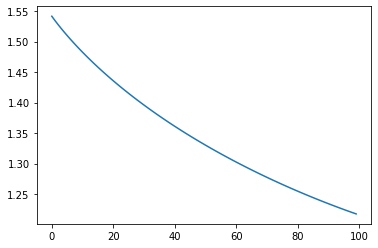

In [82]:
#ロジスティックの精度が悪いので、混合すればするほど精度悪くなる。
plt.plot(b)

## Lightgbm
### パラメータチューニングの良い方法が不明。


In [179]:
# modeling
import lightgbm as lgb
#from catboost import CatBoostClassifier, Pool

In [151]:
train = lgb.Dataset(df_train_x, label=df_train_y)
#category有のとき(事前にint型に変更必要)
#train_data = lgb.Dataset(data, label=label, feature_name=['c1', 'c2', 'c3'], categorical_feature=['c3'])

valid = train.create_valid(df_test_x, label=df_test_y)

In [180]:
# Hold Out Validation -----

# parameters update
param = {
        'boosting':'gbdt',
        'objective': 'multiclass',
        'num_class':8,
        'metric': {'multi_logloss'},
#        'metric':'auc',
#        'num_iterations':np.argmax(asses['multi_logloss-mean']),
        'num_leaves':100,
        'min_data_in_leaf':15,
        'learning_rate':0.001,
        'sub_feature':0.7,
        'sub_row':0.7,
        'bagging_freq':1,
        'lambda_l1':0.1,
        'lambda_l2':0.1,
        'num_threads':10,
        'seed':88 #乱数シード値設定
        }

num_round = 2000
m_lgb = lgb.train(param, train, num_round, valid_sets=[valid], early_stopping_rounds=1500)


[1]	valid_0's multi_logloss: 1.61781
Training until validation scores don't improve for 1500 rounds.
[2]	valid_0's multi_logloss: 1.61731
[3]	valid_0's multi_logloss: 1.61684
[4]	valid_0's multi_logloss: 1.61634
[5]	valid_0's multi_logloss: 1.61587
[6]	valid_0's multi_logloss: 1.61541
[7]	valid_0's multi_logloss: 1.61492
[8]	valid_0's multi_logloss: 1.61448
[9]	valid_0's multi_logloss: 1.61402
[10]	valid_0's multi_logloss: 1.61355
[11]	valid_0's multi_logloss: 1.6131
[12]	valid_0's multi_logloss: 1.61262
[13]	valid_0's multi_logloss: 1.61216
[14]	valid_0's multi_logloss: 1.61169
[15]	valid_0's multi_logloss: 1.61124
[16]	valid_0's multi_logloss: 1.61083
[17]	valid_0's multi_logloss: 1.6104
[18]	valid_0's multi_logloss: 1.60993
[19]	valid_0's multi_logloss: 1.60947
[20]	valid_0's multi_logloss: 1.60899
[21]	valid_0's multi_logloss: 1.60855
[22]	valid_0's multi_logloss: 1.60811
[23]	valid_0's multi_logloss: 1.60769
[24]	valid_0's multi_logloss: 1.60724
[25]	valid_0's multi_logloss: 1.606

In [191]:
import japanize_matplotlib 

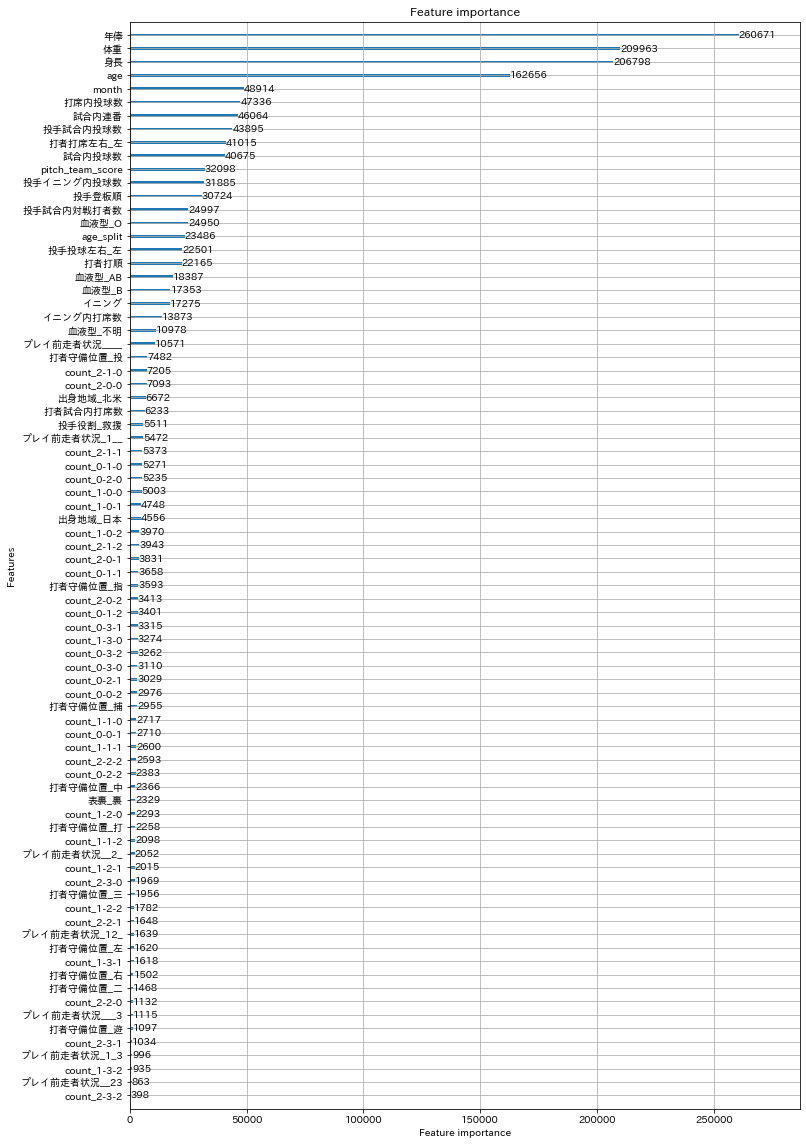

In [193]:
lgb.plot_importance(m_lgb, figsize=(12, 20))

In [194]:
pred_tr = pd.DataFrame(m_lgb.predict(df_train_x, num_iteration=m_lgb.best_iteration)) #確率予測
pred_te = pd.DataFrame(m_lgb.predict(df_test_x, num_iteration=m_lgb.best_iteration)) #確率予測

In [195]:
# 評価関数　logloss関数
print('Train:' +str(round(log_loss(df_train_y,pred_tr),4)))
print('test:' +str(round(log_loss(df_test_y,pred_te),4)))

Train:1.2781
test:1.2983


In [196]:
submit_lightgbm = pd.DataFrame(m_lgb.predict(df_test_merge, num_iteration=m_lgb.best_iteration)) #確率予測

In [197]:
submit_lightgbm

,0,1,2,3,4,5,6,7
0,0.675849,0.043538,0.109835,0.079646,0.041421,0.018417,0.004801,0.026494
1,0.621566,0.075204,0.119957,0.085009,0.045438,0.019640,0.005107,0.028079
2,0.466484,0.108525,0.152929,0.107432,0.098097,0.026057,0.006715,0.033761
3,0.449452,0.135017,0.163965,0.113566,0.068678,0.026765,0.007142,0.035415
4,0.447124,0.101959,0.167723,0.115206,0.097830,0.027534,0.007359,0.035264
...,...,...,...,...,...,...,...,...
521645,0.503343,0.061415,0.134608,0.051739,0.193917,0.026755,0.006018,0.022205
521646,0.519121,0.087694,0.145972,0.053755,0.136039,0.029650,0.005784,0.021986
521647,0.522013,0.067299,0.140591,0.053737,0.159138,0.029631,0.005752,0.021840
521648,0.515348,0.060881,0.135164,0.049973,0.182632,0.028959,0.005612,0.021432


In [200]:
b = pd.DataFrame()
for i in range(0,100):
    a = pd.DataFrame((predict_test_label*i+pred_te*(100-i))/200)
    a = log_loss(df_test_y,a)
    a = pd.DataFrame([a],[i],['score'])
    b = pd.concat([b,a],axis=0)

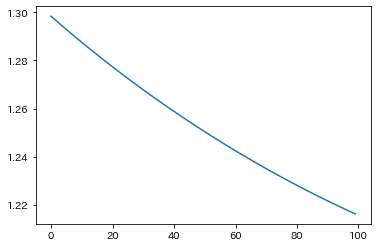

In [202]:
#ロジスティックの精度が悪いので、混合すればするほど精度悪くなる。
plt.plot(b)

In [210]:
submit_mix = (submit_label+submit_lightgbm)/2

In [198]:
submit_lightgbm.to_csv("200512_submit_lightgbm.csv",header=False,index=True)

In [211]:
submit_mix.to_csv("200512_submit_mix.csv",header=False,index=True)

In [176]:
import optuna.integration.lightgbm as lgb